In [1]:

import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import sys
print(sys.executable)
sys.path.insert(1, '../src/')
from config import raw_data_path, univariate_data_path, processed_data_path, models_path
from skopt import gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args
from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import matplotlib.pyplot as plt
from FCMAE_model import FCMAE, ConvNeXtBlock1D


/home/nwertheim/miniconda3/bin/python
/home/nwertheim/miniconda3/bin/python


In [2]:
train_file = os.path.join(univariate_data_path, 'merged_univariate_train.npy')
train_data = np.load(train_file, allow_pickle=True)
test_file = os.path.join(univariate_data_path, 'merged_univariate_test.npy')
test_data = np.load(test_file, allow_pickle=True)
print(train_data.shape)
print(test_data.shape)

print(train_data[0]['signal'].shape)
print(train_data[0])



(532,)
(134,)
(72200, 1)
{'record_name': 'ice002_p_2of3', 'signal': array([[-12.15116958],
       [-24.48972151],
       [-18.22349939],
       ...,
       [  3.40956282],
       [  1.22642183],
       [  4.90008321]]), 'metadata': {'fs': 20, 'sig_len': 746000, 'n_sig': 16, 'base_date': None, 'base_time': None, 'units': ['mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV', 'mV'], 'comments': ['Info:', 'ID:ice002', 'Record type:pregnancy', 'Record number:2/3', 'Age(years):38', 'BMI before pregnancy:20.7', 'BMI at recording:25.9', 'Gravidity:4', 'Parity:1', 'Previous caesarean:No', 'Placental position:Posterior', 'Gestational age at recording(w/d):39/1', 'Gestational age at delivery:40/4', 'Mode of delivery:Vaginal', 'Synthetic oxytocin use in labour:No', 'Epidural during labour:No', 'Comments for recording:', 'Reference on right hip - apparent reverse ECG.', 'Comments for delivery:']}}


In [3]:
import numpy as np
import pandas as pd

# Function to create time windows from the signal data
def create_time_windows(data, window_length=12000, step_size=12000):
    """
    Create sliding windows of a specified length and step size from a list of signals.

    Args:
        data: list of dicts, each containing a 'signal' array of shape (seq_len, 1)
        window_length: number of time steps in each window
        step_size: number of time steps to move between windows (for overlap)

    Returns:
        np.ndarray: shape (num_windows, window_length), univariate windows
    """
    windows = []

    for entry in data:
        signal = entry['signal'].flatten()  # shape: (seq_len,)
        signal_length = len(signal)

        if signal_length < window_length:
            continue

        for start_idx in range(0, signal_length - window_length + 1, step_size):
            end_idx = start_idx + window_length
            window = signal[start_idx:end_idx]
            windows.append(window)

    return np.array(windows)  # shape: (num_windows, window_length)


X_train = create_time_windows(train_data)
X_test = create_time_windows(test_data)
print(X_train.shape)
print(X_test.shape)

(1230, 12000)
(320, 12000)


In [4]:
def mask_data(x, mask_ratio=0.5, patch_size=8):
    """
    Apply patch-based masking to a batch of univariate time series.

    Args:
        x: np.ndarray of shape (num_windows, window_length)
        mask_ratio: float, fraction of patches to mask
        patch_size: int, number of time steps in each patch

    Returns:
        np.ndarray: masked version of x with same shape
    """
    x_masked = np.copy(x)
    num_windows, window_length = x.shape
    num_patches = window_length // patch_size

    for i in range(num_windows):
        mask = np.random.rand(num_patches) < mask_ratio
        for j in range(num_patches):
            if mask[j]:
                start = j * patch_size
                end = (j + 1) * patch_size
                x_masked[i, start:end] = 0  # or np.nan if you prefer

    return x_masked

# Apply masking to train, validation, and test sets
mask_ratio = 0.75  # Adjust this to your desired masking ratio
masked_X_train = mask_data(X_train, mask_ratio)
masked_X_test = mask_data(X_test, mask_ratio)

# Check the shape of the masked datasets
print(f"Masked Training set shape: {masked_X_train.shape}")
print(f"Masked Test set shape: {masked_X_test.shape}")

Masked Training set shape: (1230, 12000)
Masked Test set shape: (320, 12000)


In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
import optuna
import numpy as np
import joblib
import os

# Ensure you define your FCMAE and any required components above this.

# Example dataset (masked and original inputs)
masked_X_tensor = torch.tensor(masked_X_train, dtype=torch.float32).unsqueeze(1)
original_X_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def objective(trial):
    # Hyperparameter suggestions
    num_blocks = trial.suggest_int("num_blocks", 2, 5)
    kernel_size = trial.suggest_categorical("kernel_size", [3, 5, 7, 9])
    base_dim = trial.suggest_categorical("base_dim", [32, 64, 128])
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    fold_losses = []

    print(f"Starting Trial {trial.number}...")

    for fold, (train_idx, val_idx) in enumerate(kf.split(masked_X_tensor)):
        train_dataset = TensorDataset(masked_X_tensor[train_idx], original_X_tensor[train_idx])
        val_dataset = TensorDataset(masked_X_tensor[val_idx], original_X_tensor[val_idx])

        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

        model = FCMAE(in_channels=1, base_dim=base_dim, num_blocks=num_blocks, kernel_size=kernel_size).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()

        # Train for a few epochs
        for epoch in range(5):
            model.train()
            for masked_input, original_input in train_loader:
                masked_input = masked_input.to(device)
                original_input = original_input.to(device)

                optimizer.zero_grad()
                reconstructed = model(masked_input)
                loss = criterion(reconstructed, original_input)
                loss.backward()
                optimizer.step()

        # Evaluate
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for masked_input, original_input in val_loader:
                masked_input = masked_input.to(device)
                original_input = original_input.to(device)

                reconstructed = model(masked_input)
                loss = criterion(reconstructed, original_input)
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)
        fold_losses.append(avg_val_loss)

        # print(f"  Fold {fold+1} val loss: {avg_val_loss:.4f}")

    mean_val_loss = np.mean(fold_losses)
    print(f"Trial {trial.number} completed - Mean CV Loss: {mean_val_loss:.4f}")
    return mean_val_loss

# Run Optuna optimization
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=25)

# Print best result
print("Best trial:")
print(study.best_trial)

# Save the Optuna study
path = os.path.join(models_path, "fcmae_cv_optuna_updated.pkl")
joblib.dump(study, path)
print(f"Saved Optuna study to {path}")


/home/nwertheim/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-04-24 17:49:19,687] A new study created in memory with name: no-name-c500c250-5447-46c0-81ce-3c3a3c0c2512


Starting Trial 0...


[I 2025-04-24 18:04:54,050] Trial 0 finished with value: 0.07770528523251415 and parameters: {'num_blocks': 3, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 9.114143739760289e-05, 'batch_size': 32}. Best is trial 0 with value: 0.07770528523251415.


Trial 0 completed - Mean CV Loss: 0.0777
Starting Trial 1...


[I 2025-04-24 18:26:47,422] Trial 1 finished with value: 0.04911477765999735 and parameters: {'num_blocks': 5, 'kernel_size': 9, 'base_dim': 64, 'learning_rate': 0.00059266703042723, 'batch_size': 32}. Best is trial 1 with value: 0.04911477765999735.


Trial 1 completed - Mean CV Loss: 0.0491
Starting Trial 2...


[I 2025-04-24 18:34:29,836] Trial 2 finished with value: 0.4484880559146404 and parameters: {'num_blocks': 3, 'kernel_size': 3, 'base_dim': 64, 'learning_rate': 0.0009533170527479427, 'batch_size': 32}. Best is trial 1 with value: 0.04911477765999735.


Trial 2 completed - Mean CV Loss: 0.4485
Starting Trial 3...


[I 2025-04-24 18:41:56,020] Trial 3 finished with value: 0.07962751630693674 and parameters: {'num_blocks': 4, 'kernel_size': 7, 'base_dim': 64, 'learning_rate': 0.0004303710288705274, 'batch_size': 64}. Best is trial 1 with value: 0.04911477765999735.


Trial 3 completed - Mean CV Loss: 0.0796
Starting Trial 4...


[I 2025-04-24 18:59:53,370] Trial 4 finished with value: 0.49681561887264253 and parameters: {'num_blocks': 2, 'kernel_size': 5, 'base_dim': 32, 'learning_rate': 4.427735305708041e-05, 'batch_size': 32}. Best is trial 1 with value: 0.04911477765999735.


Trial 4 completed - Mean CV Loss: 0.4968
Starting Trial 5...


[I 2025-04-24 19:31:00,638] Trial 5 finished with value: 0.3667494185268879 and parameters: {'num_blocks': 2, 'kernel_size': 5, 'base_dim': 64, 'learning_rate': 0.0004609303252303699, 'batch_size': 16}. Best is trial 1 with value: 0.04911477765999735.


Trial 5 completed - Mean CV Loss: 0.3667
Starting Trial 6...


[I 2025-04-24 20:12:23,298] Trial 6 finished with value: 0.04877666188403964 and parameters: {'num_blocks': 5, 'kernel_size': 7, 'base_dim': 128, 'learning_rate': 0.00012245258864780221, 'batch_size': 32}. Best is trial 6 with value: 0.04877666188403964.


Trial 6 completed - Mean CV Loss: 0.0488
Starting Trial 7...


[I 2025-04-24 20:21:02,501] Trial 7 finished with value: 0.2367649994790554 and parameters: {'num_blocks': 4, 'kernel_size': 3, 'base_dim': 64, 'learning_rate': 2.607900007333144e-05, 'batch_size': 32}. Best is trial 6 with value: 0.04877666188403964.


Trial 7 completed - Mean CV Loss: 0.2368
Starting Trial 8...


[I 2025-04-24 20:36:28,634] Trial 8 finished with value: 0.5945203900337219 and parameters: {'num_blocks': 2, 'kernel_size': 3, 'base_dim': 32, 'learning_rate': 0.0005617274111701459, 'batch_size': 32}. Best is trial 6 with value: 0.04877666188403964.


Trial 8 completed - Mean CV Loss: 0.5945
Starting Trial 9...


[I 2025-04-24 21:31:58,775] Trial 9 finished with value: 0.07338925693184137 and parameters: {'num_blocks': 5, 'kernel_size': 7, 'base_dim': 32, 'learning_rate': 1.859497493473237e-05, 'batch_size': 16}. Best is trial 6 with value: 0.04877666188403964.


Trial 9 completed - Mean CV Loss: 0.0734
Starting Trial 10...


[I 2025-04-24 22:02:01,212] Trial 10 finished with value: 0.05559737179428339 and parameters: {'num_blocks': 5, 'kernel_size': 7, 'base_dim': 128, 'learning_rate': 0.0001632809537501735, 'batch_size': 64}. Best is trial 6 with value: 0.04877666188403964.


Trial 10 completed - Mean CV Loss: 0.0556
Starting Trial 11...


[I 2025-04-24 22:48:09,293] Trial 11 finished with value: 0.04629602446220815 and parameters: {'num_blocks': 5, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 0.0001979729586672337, 'batch_size': 32}. Best is trial 11 with value: 0.04629602446220815.


Trial 11 completed - Mean CV Loss: 0.0463
Starting Trial 12...


[I 2025-04-24 23:13:58,730] Trial 12 finished with value: 0.050464970618486406 and parameters: {'num_blocks': 4, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 0.000183377069617485, 'batch_size': 32}. Best is trial 11 with value: 0.04629602446220815.


Trial 12 completed - Mean CV Loss: 0.0505
Starting Trial 13...


[I 2025-04-24 23:41:02,118] Trial 13 finished with value: 0.06467046085745096 and parameters: {'num_blocks': 5, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 0.00010024062956996219, 'batch_size': 64}. Best is trial 11 with value: 0.04629602446220815.


Trial 13 completed - Mean CV Loss: 0.0647
Starting Trial 14...


[I 2025-04-25 00:06:39,437] Trial 14 finished with value: 0.05595650346949697 and parameters: {'num_blocks': 4, 'kernel_size': 7, 'base_dim': 128, 'learning_rate': 0.00021755638221619428, 'batch_size': 32}. Best is trial 11 with value: 0.04629602446220815.


Trial 14 completed - Mean CV Loss: 0.0560
Starting Trial 15...


[I 2025-04-25 01:02:43,946] Trial 15 finished with value: 0.0393987626535818 and parameters: {'num_blocks': 5, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 5.2340352571990094e-05, 'batch_size': 16}. Best is trial 15 with value: 0.0393987626535818.


Trial 15 completed - Mean CV Loss: 0.0394
Starting Trial 16...


[I 2025-04-25 01:56:31,640] Trial 16 finished with value: 0.03617798360064626 and parameters: {'num_blocks': 5, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 5.493606514151052e-05, 'batch_size': 16}. Best is trial 16 with value: 0.03617798360064626.


Trial 16 completed - Mean CV Loss: 0.0362
Starting Trial 17...


[I 2025-04-25 02:18:18,712] Trial 17 finished with value: 0.08941644551232457 and parameters: {'num_blocks': 3, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 1.0491634484367552e-05, 'batch_size': 16}. Best is trial 16 with value: 0.03617798360064626.


Trial 17 completed - Mean CV Loss: 0.0894
Starting Trial 18...


[I 2025-04-25 02:55:57,824] Trial 18 finished with value: 0.044972276664339006 and parameters: {'num_blocks': 4, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 5.336944683635567e-05, 'batch_size': 16}. Best is trial 16 with value: 0.03617798360064626.


Trial 18 completed - Mean CV Loss: 0.0450
Starting Trial 19...


[I 2025-04-25 03:49:33,687] Trial 19 finished with value: 0.043209103564731774 and parameters: {'num_blocks': 5, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 4.411630563299171e-05, 'batch_size': 16}. Best is trial 16 with value: 0.03617798360064626.


Trial 19 completed - Mean CV Loss: 0.0432
Starting Trial 20...


[I 2025-04-25 04:16:10,691] Trial 20 finished with value: 0.08130339230410755 and parameters: {'num_blocks': 4, 'kernel_size': 5, 'base_dim': 32, 'learning_rate': 6.653326249992911e-05, 'batch_size': 16}. Best is trial 16 with value: 0.03617798360064626.


Trial 20 completed - Mean CV Loss: 0.0813
Starting Trial 21...


[I 2025-04-25 05:11:13,155] Trial 21 finished with value: 0.03826957535929978 and parameters: {'num_blocks': 5, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 3.35239005500162e-05, 'batch_size': 16}. Best is trial 16 with value: 0.03617798360064626.


Trial 21 completed - Mean CV Loss: 0.0383
Starting Trial 22...


[I 2025-04-25 06:03:42,362] Trial 22 finished with value: 0.03954411945305765 and parameters: {'num_blocks': 5, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 2.651346589379373e-05, 'batch_size': 16}. Best is trial 16 with value: 0.03617798360064626.


Trial 22 completed - Mean CV Loss: 0.0395
Starting Trial 23...


[I 2025-04-25 06:58:53,639] Trial 23 finished with value: 0.04119898483622819 and parameters: {'num_blocks': 5, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 3.158241686421226e-05, 'batch_size': 16}. Best is trial 16 with value: 0.03617798360064626.


Trial 23 completed - Mean CV Loss: 0.0412
Starting Trial 24...


[I 2025-04-25 07:53:12,431] Trial 24 finished with value: 0.04574415585957468 and parameters: {'num_blocks': 5, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 1.534729453961656e-05, 'batch_size': 16}. Best is trial 16 with value: 0.03617798360064626.


Trial 24 completed - Mean CV Loss: 0.0457
Best trial:
FrozenTrial(number=16, state=1, values=[0.03617798360064626], datetime_start=datetime.datetime(2025, 4, 25, 1, 2, 43, 947502), datetime_complete=datetime.datetime(2025, 4, 25, 1, 56, 31, 640065), params={'num_blocks': 5, 'kernel_size': 9, 'base_dim': 128, 'learning_rate': 5.493606514151052e-05, 'batch_size': 16}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'num_blocks': IntDistribution(high=5, log=False, low=2, step=1), 'kernel_size': CategoricalDistribution(choices=(3, 5, 7, 9)), 'base_dim': CategoricalDistribution(choices=(32, 64, 128)), 'learning_rate': FloatDistribution(high=0.001, log=True, low=1e-05, step=None), 'batch_size': CategoricalDistribution(choices=(16, 32, 64))}, trial_id=16, value=None)
Saved Optuna study to ../models/fcmae_cv_optuna_updated.pkl


/scratch-local/nwertheim.11367062/ipykernel_271386/863186959.py:13: ExperimentalWarning: plot_optimization_history is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_optimization_history(study)


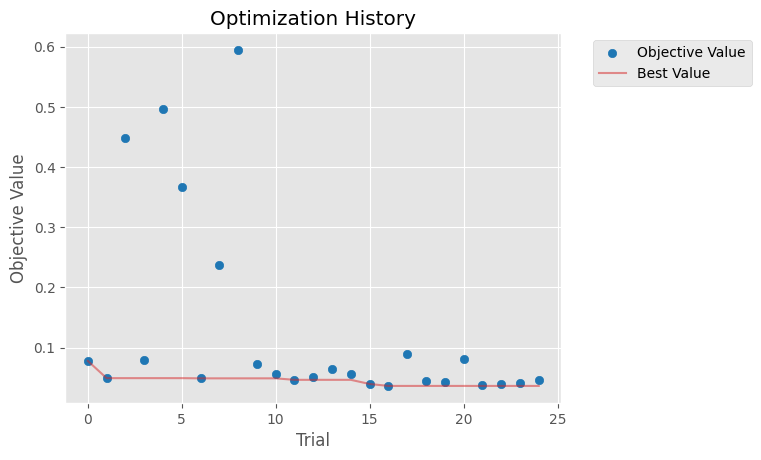

/scratch-local/nwertheim.11367062/ipykernel_271386/863186959.py:19: ExperimentalWarning: plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_param_importances(study)


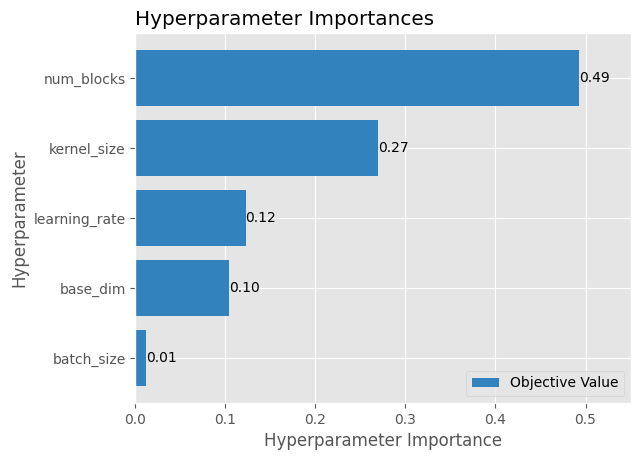

/scratch-local/nwertheim.11367062/ipykernel_271386/863186959.py:25: ExperimentalWarning: plot_parallel_coordinate is experimental (supported from v2.2.0). The interface can change in the future.
  optuna.visualization.matplotlib.plot_parallel_coordinate(study)


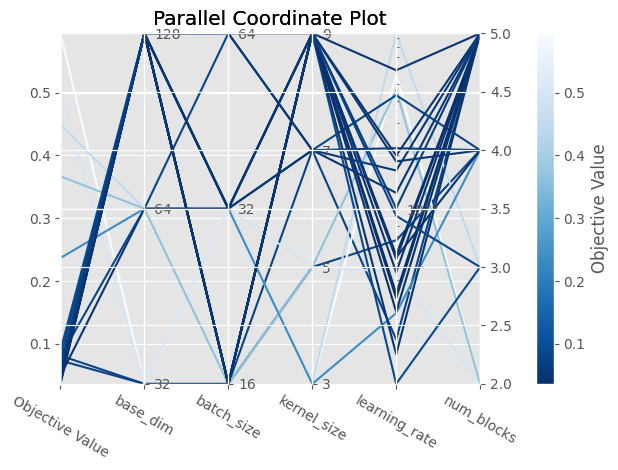

In [6]:
import os
import joblib
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances, plot_parallel_coordinate
import matplotlib.pyplot as plt


path = os.path.join(models_path, 'fcmae_cv_optuna_updated.pkl')
# Load the saved study
study = joblib.load(path)

# Plot: Optimization History
optuna.visualization.matplotlib.plot_optimization_history(study)
plt.title("Optimization History")
# plt.tight_layout()
plt.show()

# Plot: Hyperparameter Importance
optuna.visualization.matplotlib.plot_param_importances(study)
# plt.title("Hyperparameter Importance")
# plt.tight_layout()
plt.show()

# Plot: Parallel Coordinates (shows interaction between parameters)
optuna.visualization.matplotlib.plot_parallel_coordinate(study)
plt.title("Parallel Coordinate Plot")
plt.tight_layout()
plt.show()
